In [1]:
import os
import re 
from dotenv import load_dotenv
import tweepy
load_dotenv()
import json
from datetime import datetime
import logging
from openai import OpenAI
from typing import TypedDict, Optional, List, Dict, Any
from langgraph.graph import StateGraph, END, START
import google.generativeai as genai
import requests
from bs4 import BeautifulSoup
import asyncio
from IPython.display import display, Image
try:
    genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
    gemini_flash = genai.GenerativeModel("models/gemini-1.5-flash") # Re-use model
    gemini_pro = genai.GenerativeModel("models/gemini-1.5-pro") # Re-use model
except TypeError:
    logging.error("ERROR: GOOGLE_API_KEY not found. Please check your .env file.")
    exit()
except Exception as e:
    logging.error(f"Error configuring Gemini: {e}")
    exit()

try:
    openrouter_client = OpenAI(
        base_url="https://openrouter.ai/api/v1",
        api_key=os.getenv("OPENROUTER_API_KEY"),
    )
except Exception as e:
    logging.error("ERROR: OPENROUTER_API_KEY not found or invalid.")
    exit()

class State(TypedDict):
    """
    The central state for the fact-checking graph.
    It holds all inputs, intermediate results, and the final verdict.
    """
    # Inputs

    tweet_Id: str
    
    # Agent Outputs
    tweet_extraction_result: Optional[Dict[str, Any]]
    text_result: Optional[Dict[str, Any]]
    #claims_result: Optional[Dict[str, Any]]
    link_result: Optional[Dict[str, Any]]
    account_result: Optional[str]
    link_scraped_texts: Optional[List[Dict[str, str]]]
    news_scraped_texts: Optional[List[Dict[str, str]]]
    scraped_texts_Summary: Optional[List[Dict[str, str]]]
    
    # Final Output
    final_verdict: Optional[Dict[str, Any]]

def tweet_extractor_logic(tweet_id) -> Dict[str, Any]:
    """
    A node that extracts tweet information using tweepy.
    It reads the tweet_id from the state and writes the
    results back to the state.
    """
    print("---EXECUTING TWEET EXTRACTOR NODE---")
    
    # 1. Load the token safely *inside* the node
    x_bearer = os.getenv("token")
    if not x_bearer:
        print("Bearer token not found in environment variables.")
        return {"error": "Bearer token not found."}

    client = tweepy.Client(bearer_token=x_bearer)
    
    # 2. Get the tweet_id from the state
    if not tweet_id:
        print("No tweet_id in state.")
        return {"error": "tweet_id not found in state."}

    # 3. Run your extraction logic
    try:
        tweet = client.get_tweet(
            id=tweet_id,
            expansions=["attachments.media_keys", "author_id"],
            tweet_fields=["created_at", "public_metrics", "text"],
            media_fields=["url", "preview_image_url", "type"],
            user_fields=["username", "name", "profile_image_url"]
        )

        if tweet.data is None:
            # Handle cases where the tweet wasn't found
            return {"error": f"Tweet {tweet_id} not found or access is restricted."}

        list_data = {}
        list_data['text'] = tweet.data.text
        list_data['created_at'] = tweet.data.created_at
        
        metrics = tweet.data.public_metrics
        list_data['likes'] = metrics['like_count']
        list_data['retweets'] = metrics['retweet_count']
        list_data['replies'] = metrics['reply_count']

        # Safer way to handle 'includes'
        users = {user.id: user for user in tweet.includes.get('users', [])}
        author_id = tweet.data.author_id
        if author_id in users:
            list_data['username'] = users[author_id].username
            list_data['name'] = users[author_id].name
            list_data['profile_image_url'] = users[author_id].profile_image_url

        if "media" in tweet.includes:
            media_urls = []
            for media in tweet.includes['media']:
                media_type = media.type
                media_url = getattr(media, "url", getattr(media, "preview_image_url", None))
                media_urls.append({'type': media_type, 'url': media_url})
            list_data['media'] = media_urls

        # 4. Return the dictionary to update the state
        # This will merge { "extracted_data": ... } into the state
        return {"extracted_data": list_data, "error": None}

    except Exception as e:
        print(f"An error occurred: {e}")
        return {"error": str(e)}

async def extract_points_logic(tweet_text: str) -> Dict[str, Any]:
    """
    Extracts claims/summaries from a tweet into a structured JSON list.
    
    Returns: A dictionary, e.g., {"points": ["claim 1", "point 2"]}
             or {"error": "message"}
    """
    
    prompt = f"""
    You are a summarization expert. Your task is to read the following tweet
    and extract all distinct factual claims, opinions, and main summary points.

    Tweet: "{tweet_text}"

    Respond ONLY with a valid JSON object in the following structure:
    {{
      "points": [
        "<The first claim or point>",
        "<The second claim or point>",
        "<etc.>"
      ]
    }}

    If no claims or points are found, return {{"points": []}}.
    """
    
    try:
        response = await gemini_flash.generate_content(prompt)
        # Clean and parse the JSON response
        cleaned_json_string = response.text.strip().lstrip("```json").rstrip("```")
        return json.loads(cleaned_json_string)

    except json.JSONDecodeError:
        logging.error(f"JSON Decode Error: Could not parse model response - {response.text}")
        return {"error": "Failed to parse the model's response as JSON."}
    except Exception as e:
        logging.error(f"An unexpected error occurred: {e}")
        return {"error": f"An API or other unexpected error occurred: {str(e)}"}
    
async def summarize_text_logic(article_text:str)->str:
    """
    Summarizes a long article text into a dense, factual summary.
    
    Returns: {"summary": "The article discusses..."} or {"error": "..."}
    """
    
    prompt = f"""
    You are an expert summarizer. Read the following article text and
    distill it into a single, dense, factual paragraph.
    Focus only on the main conclusions, evidence, and factual statements.
    Omit all opinions, filler, and introductory sentences.

    Article Text (may be long):
    "{article_text}"

    Respond ONLY with a valid JSON object:
    {{
      "summary": "<Your dense, factual summary paragraph here>"
    }}
    """
    
    try:
        # NOTE: This prompt is for a model with a large context window
        # like gemini-1.5-flash. If using a smaller model,
        # you may need to truncate article_text: {article_text[:8000]}
        response = await gemini_flash.generate_content(prompt)
        
        cleaned_json_string = response.text.strip().lstrip("```json").rstrip("```")
        return json.loads(cleaned_json_string)

    except json.JSONDecodeError:
        logging.error(f"JSON Decode Error in summarizer: {response.text}")
        return {"error": "Failed to parse the summarizer model's response."}
    except Exception as e:
        logging.error(f"An unexpected error in summarizer: {e}")
        return {"error": f"An API or other unexpected error occurred: {str(e)}"}


#@tobeUsed
def text_claim_logic(tweet_text):
    prompt = f"""
    You are an expert fact-checker specializing in social media content.
    Analyze the credibility of the following tweet.

    Tweet: "{tweet_text}"

    Follow these steps carefully:
    1.  **Extract Claims**: Identify and list the main factual claim(s). If the tweet is purely an opinion, satire, or a question, explicitly state that in the list.
    2.  **Assess Credibility**: Assign a credibility score to the **factual claims only**. The score should be an integer from 0 (verifiably false) to 100 (verifiably true). If the tweet contains no factual claim (e.g., it's just an opinion), the score must be `null`.
    3.  **Explain Reasoning**: Provide a brief, neutral explanation for your score.

    Respond ONLY with a valid JSON object following this structure:
    {{
      "claims": ["List of claims or a statement that it's an opinion."],
      "credibility_score": <integer or null>,
      "explanation": "Your concise reasoning here."
    }}
    """
    try:
        response = gemini_flash.generate_content(prompt)
        cleaned_json_string = response.text.strip().lstrip("```json").rstrip("```")
        return json.loads(cleaned_json_string)
    except json.JSONDecodeError:
        logging.error(f"JSON Decode Error: Could not parse model response - {response.text}")
        return {"error": "Failed to parse the model's response as JSON."}
    except Exception as e:
        logging.error(f"An unexpected error occurred: {e}")
        return {"error": f"An API or other unexpected error occurred: {str(e)}"}

#@tobeUsed
def verifier_agent_logic(tweet_points_result: Dict[str, Any], article_summary_result: Dict[str, Any]):
    """
    Compares tweet claims against a scraped article summary
    to check for support, contradiction, or no overlap.
    """
    if tweet_points_result.get("error"):
        logging.error("Tweet claims extraction failed.")
        return {"error": "Cannot verify, the tweet claims extraction failed."}
    if article_summary_result.get("error"):
        logging.error("Article summarization failed.")
        return {"error": "Cannot verify, the article summarization failed."}
    claims_list = tweet_points_result.get("points", [])
    article_summary = article_summary_result.get("summary", "")

    if not claims_list:
        return {
            "overall_verdict": "No Claims",
            "explanation": "The tweet contained no factual claims to verify.",
            "results": []
        }
    if not article_summary:
        return {
            "overall_verdict": "No Evidence",
            "explanation": "The article summary was empty, cannot verify claims.",
            "results": []
        }
    
    prompt = f"""
    You are a meticulous fact-checking agent. Your job is to compare a list of claims
    from a tweet against the summary of a linked article.

    **Tweet Claims (List A):**
    {json.dumps(claims_list, indent=2)}

    **Linked Article Summary (Text B):**
    "{article_summary}"

    **Your Task:**
    For *each* claim in List A, determine if it is supported,
    contradicted, or not mentioned by Text B.
    Base your verdict *only* on the provided summary.

    Respond ONLY with a valid JSON object:
    {{
      "overall_verdict": "<One of 'Fully Supported', 'Partially Supported', 'Contradicted', 'No Overlap'>",
      "explanation": "<A brief summary of your findings.>",
      "results": [
        {{
          "claim": "<The original claim from List A>",
          "verdict": "<One of 'Supported', 'Contradicted', 'Not Mentioned'>",
          "reasoning": "<A brief explanation for your verdict, citing Text B if possible.>"
        }}
      ]
    }}
    """
    # --- 4. Call LLM and Return Results ---
    try:
        response = gemini_flash.generate_content(prompt)
        cleaned_json_string = response.text.strip().lstrip("```json").rstrip("```")
        return json.loads(cleaned_json_string)

    except json.JSONDecodeError:
        logging.error(f"JSON Decode Error in verifier: {response.text}")
        return {"error": "Failed to parse the verifier model's response."}
    except Exception as e:
        logging.error(f"An unexpected error in verifier: {e}")
        return {"error": f"An API or other unexpected error occurred: {str(e)}"}

async def web_scraping(url: str):
    html = await requests.get(url).text
    b = BeautifulSoup(html,'html.parser')
    te = b.get_text()
    cleaned_text =te.replace('\n', '').replace('\t', '')
    return cleaned_text


async def analyze_x_account_logic(username_or_id, num_posts="50", time_range="6 months"):
    today = datetime.now().strftime("%Y-%m-%d")
    prompt = f"""
    Analyze the X account [@username or user_id: {username_or_id}] for credibility and hate speech risk as a fact-checking agent. Fetch up to [NUM_POSTS: {num_posts}] recent posts from the last [TIME_RANGE: {time_range}] using X tools. Use these factors, weighted equally unless specified:

    1. Transparency: % posts with evidence (links OR references).
    2. Non-Partisanship: Topic diversity; retweet balance.
    3. Methodology: Verify 3-5 sample claims via web search (e.g., match to PolitiFact/Snopes).
    4. Account History: Patterns of consistency; flag repeats of debunked topics.
    5. Engagement: Avg likes/replies; % toxic replies (semantic search for "fake" or "hate").
    6. Hate Risk: Scan for slurs, threats, bias; % flagged posts.

    Output:
    - Overall Credibility Score: [0-100], with Low/Med/High label.
    - Hate Risk: Low/Med/High, with % flagged.
    - Table: Factor | Score (0-10) | Evidence (2-3 examples).
    - Recommendations: e.g., "Trust for neutral topics; flag political claims."

    Handle media accounts leniently if verified/high-followers but low links—focus on history. Current date: [{today}].
    """
    try:
        completion = openrouter_client.chat.completions.create(
            model="x-ai/grok-1", # Using Grok-1 for this task
            messages=[
                {"role": "system", "content": "You are a fact-checking agent with access to X tools, web search, and semantic analysis capabilities. Respond in the specified output format."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.5,
            max_tokens=1500
        )
        return completion.choices[0].message.content
    except Exception as e:
        logging.error(f"Error calling OpenRouter: {e}")
        return f"Error: Failed to analyze account {username_or_id}. {str(e)}"

def main_brain_logic(text_result, link_result, x_account_result):
    prompt = f"""
    You are a master intelligence analyst. Your mission is to synthesize reports from three specialist agents to determine the overall credibility of a tweet.

    **Agent Reports:**

    1.  **Text & Claim Analysis**:
        ```json
        {json.dumps(text_result, indent=2)}
        ```

    2.  **Link & Source Analysis**:
        ```json
        {json.dumps(link_result, indent=2)}
        ```

    3.  **X Account Analysis (Raw Text from Grok)**:
        ```text
        {x_account_result}
        ```

    **Reasoning Framework:**
    -   **Conflict is a Red Flag**: If the claim's score is high but the source and/or account scores are low, the verdict should be **"Misleading"**.
    -   **No Sources**: If no links were provided, rely more on text plausibility and account reputation.
    -   **Opinions**: If the text is an opinion, the verdict must be **"Opinion/Unverifiable"**.
    -   **Errors**: If any agent report contains an "error" field, acknowledge it and lower your confidence.

    **Final Task:**
    Based on all available data, provide a final verdict. Respond ONLY with a valid JSON object.

    {{
      "final_verdict": "One of ['Verified True', 'Likely True', 'Misleading', 'Likely False', 'Verified False', 'Opinion/Unverifiable']",
      "overall_score": <integer from 0 to 100>,
      "reason": "A concise explanation justifying your verdict by referencing the key findings from the three agent reports."
    }}
    """
    try:
        response = gemini_pro.generate_content(prompt)
        cleaned_json_string = response.text.strip().lstrip("```json").rstrip("```")
        return json.loads(cleaned_json_string)
    except json.JSONDecodeError:
        logging.error(f"JSON Decode Error in main brain agent: {response.text}")
        return {"error": "Failed to parse the final verdict from the model."}
    except Exception as e:
        logging.error(f"An unexpected error occurred in main brain agent: {e}")
        return {"error": f"An API or other unexpected error occurred: {str(e)}"}
    
def tweet_extractor_node(state: State) -> Dict[str, Any]:
    """Node to run the Extracting Tweet Data."""
    logging.info("Running Node: tweet_extractor_node")

    tweet_id = state.get("tweet_Id")
    data = tweet_extractor_logic(tweet_id)

    if not data or data.get("error"):
        logging.error(f"Tweet extraction failed: {data.get('error')}")
        return {"error": data.get("error")}

    # ✅ Return properly under expected key
    return {"tweet_extraction_result": data["extracted_data"]}


def text_claim_node(state: State) -> Dict[str, Any]:
    """Node to run the text and claim analysis."""
    logging.info("Running Node: text_claim_node")
    tweet = state.get("tweet_extraction_result")
    tweet_text = tweet.get("text")
    result = text_claim_logic(tweet_text)
    return {"text_result": result}

"""
def link_agent_node(state: State) -> Dict[str, Any]:
    """"Node to run the link and source analysis.""""
    logging.info("Running Node: link_agent_node")
    tweet = state.get("tweet_extraction_result")
    tweet_text = tweet.get("text")
    result = link_agent_logic(tweet_text)
    return {"link_result": result}

"""
def analyze_x_account_node(state: State) -> Dict[str, Any]:
    """Node to run the X account analysis."""
    logging.info("Running Node: analyze_x_account_node")
    tweet = state.get("tweet_extraction_result")
    username = tweet.get("username")
    result = analyze_x_account_logic(username)
    return {"account_result": result}

def main_brain_node(state: State) -> Dict[str, Any]:
    """Node to run the final aggregation."""
    logging.info("Running Node: main_brain_node")
    text_result = state["text_result"]
    link_result = state["link_result"]
    account_result = state["account_result"]

    result = main_brain_logic(text_result, link_result, account_result)
    return {"final_verdict": result}

def extract_points_node(state: State)-> Dict[str,Any]:
    logging.info("Running Node: claims_node")
    tweet = state.get("tweet_extraction_result")
    tweet_text = tweet.get("text")
    result = extract_points_logic(tweet_text)
    return {"claims_result": result}

def web_scraping_node(state: State) -> Dict[str, Any]:
    logging.info("Running Node: web_scraping_node")
    tweet = state.get("tweet_extraction_result")
    tweet_text = tweet.get("text")
    links = re.findall(r'(https?://\S+)', tweet_text)
    if not links:
        return {"scraped_texts": []}
    
    scraped_texts = []
    for link in links:
        scraped_content = web_scraping(link)
        scraped_texts.append({"link": link, "content": scraped_content})
    
    return {"link_scraped_texts": scraped_texts}

def summarize_scraped_texts_node(state: State) -> Dict[str, Any]:
    logging.info("Running Node: summarize_scraped_texts_node")
    scraped_texts = state.get("link_scraped_texts", [])
    summarized_texts = []
    for item in scraped_texts:
        link = item["link"]
        content = item["content"]
        summary = summarize_text_logic(content)
        summarized_texts.append({"link": link, "summary": summary.get("summary", "")})
    
    return {"scraped_texts_Summary": summarized_texts}

def verifier_agent_node(state: State) -> Dict[str, Any]:
    logging.info("Running Node: verifier_agent_node")
    tweet_points_result = state.get("text_result", {})
    article_summary_result = state.get("scraped_texts_Summary", {})
    result = verifier_agent_logic(tweet_points_result, article_summary_result)
    return {"link_result": result}


def media_type(state:State):
    extraction_data = state.get("tweet_extraction_result")
    if not extraction_data or extraction_data.get("error"):
        print("Routing: Error or no data. Routing to 'error_route'")
        return "end"
    media_list = extraction_data.get("media")
    if not media_list:
        print("Routing: No media found. Routing to 'no_media_route'")
        return "end"
    first_media_item = media_list[0]
    media_type = first_media_item.get("type")

    if media_type == 'video':
        print(f"Routing: Media type is 'video'. Routing to 'video_route'")
        return "video_route"
    elif media_type == 'photo':
        print(f"Routing: Media type is 'photo'. Routing to 'photo_route'")
        return "photo_route"
    else:
        return "end"

# Initialize the StateGraph
workflow = StateGraph(State)

# Add nodes
workflow.add_node("tweet_extractor", tweet_extractor_node)
workflow.add_node("text_claim", extract_points_node)
workflow.add_node("web_scraping", web_scraping_node)
workflow.add_node("summarization", summarize_scraped_texts_node)
workflow.add_node("account_analysis", analyze_x_account_node)
workflow.add_node("verifier_agent", verifier_agent_node)
workflow.add_node("aggregator", main_brain_node)

# Parallel branches from tweet_extractor
workflow.add_edge(START, "tweet_extractor")
workflow.add_edge("tweet_extractor", "text_claim")
workflow.add_edge("tweet_extractor", "web_scraping")
workflow.add_edge("tweet_extractor", "account_analysis")

# Dependent branches
workflow.add_edge("web_scraping", "summarization")
workflow.add_edge("summarization", "verifier_agent")

# Merge all into aggregator
workflow.add_edge("text_claim", "aggregator")
workflow.add_edge("verifier_agent", "aggregator")
workflow.add_edge("account_analysis", "aggregator")

# End after aggregation
workflow.add_edge("aggregator", END)

# Compile
app = workflow.compile()

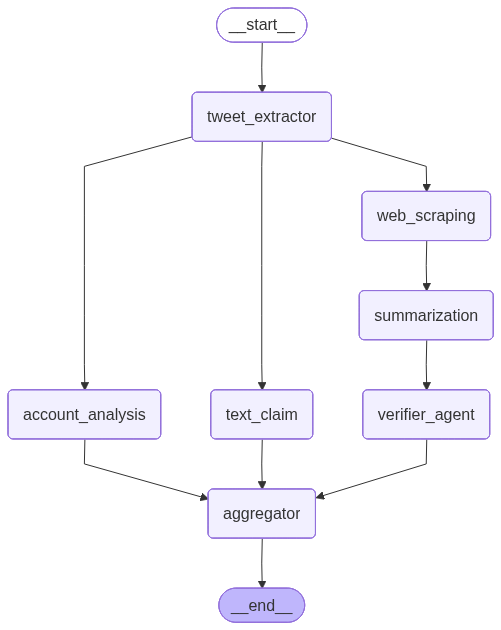

In [2]:
display(
        Image(
            app.get_graph().draw_mermaid_png()
        )
    )